In [79]:
# reload magics
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from math import log10

from project_modules.utils import get_logger
logger = get_logger("log-data-umap.log")
# read the parameter file

from project_modules.utils import read_parameters
parms = read_parameters("/Users/david/projects/lc-project-data/project.yaml")

[2024-04-05 08:19:51] [get_logger] Logger initialized.
[2024-04-05 08:19:51] [get_logger] Logging to file: log-data-umap.log
[2024-04-05 08:19:51] [read_parameters] Reading parameters.
[2024-04-05 08:19:51] [read_parameters] ... reading /Users/david/projects/lc-project-data/project.yaml


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
parms

{'project': 'lc',
 'dir_raw_data': '/Users/david/projects/lc-project-data/raw-data',
 'dir_proc_data': '/Users/david/projects/lc-project-data/processed-data',
 'dir_output': '/Users/david/projects/lc-project-data/output',
 'file_raw_data': 'specimen-data.xlsx'}

In [81]:
from pathlib import Path
input_dir = Path(parms["dir_proc_data"])
ipath = Path(input_dir / "SYNTHETIC_features")
ipath

PosixPath('/Users/david/projects/lc-project-data/processed-data/SYNTHETIC_features')

In [82]:
from project_modules.io import load_dataset_to_df
df = load_dataset_to_df(ipath, verbose = True)

from datasets import Dataset

labels = Dataset.load_from_disk(Path(parms['dir_proc_data']) / "SYNTHETIC_labels")

[2024-04-05 08:19:52] [load_dataset_to_df] Loading data from /Users/david/projects/lc-project-data/processed-data/SYNTHETIC_features...
[2024-04-05 08:19:52] [load_dataset_to_df] Converting to dataframe...
[2024-04-05 08:19:52] [load_dataset_to_df] Shape: (1000, 25)


In [83]:
# select all but the datetime64 types
df = df.select_dtypes(exclude=['datetime64', 'object'])

In [84]:
# split into train and test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# split into train and test
X = df
y = pd.DataFrame(labels['TRUE_LABEL'], columns=['TRUE_LABEL'])
X_train, X_test,\
     y_train, y_test = train_test_split(X, y, test_size=0.3)

# split the X_test into eval and holdout
X_eval, X_holdout,\
     y_eval, y_holdout = train_test_split(X_test, y_test, test_size=0.5)

In [85]:
X_train.shape, X_eval.shape, X_holdout.shape


((700, 25), (150, 25), (150, 25))

In [44]:
y_train.shape, y_eval.shape, y_holdout.shape

((700, 1), (150, 1), (150, 1))

In [86]:
# import umap, hdbscan
# um   = umap.UMAP(
#                         metric       = 'euclidean', 
#                         min_dist     = 0.1,  
#                         # random_state = 42, 
#                     )

# # fit a dimensionality-reducer to the training data
# um.fit(X_train)

# # transform the training data
# X_train_reduced = um.transform(X_train)

# # use HDBSCAN to generate a cluster id
# clusterer = hdbscan.HDBSCAN(
#     min_cluster_size = 50,
#     min_samples      = 10,
#     cluster_selection_epsilon = 0.5,
#     metric           = 'euclidean',
#     prediction_data  = True,
# )

# clusterer.fit(X_train_reduced)

# # assign the cluster id to the training data
# X_train_reduced = pd.DataFrame(X_train_reduced, columns = ['UMAP1', 'UMAP2'])
# X_train_reduced['CLUSTER_ID'] = clusterer.labels_





In [87]:
X_train.shape

(700, 25)

In [90]:
# use HDBSCAN to generate a cluster id
clusterer = hdbscan.HDBSCAN(
    # min_cluster_size = 20,
    # min_samples      = 10,
    # cluster_selection_epsilon = 0.5,
    # metric           = 'euclidean',
    prediction_data  = True,
)

clusterer.fit(X_train)

labels = clusterer.labels_

In [91]:
set(labels)

{-1}

In [73]:
# now reduce dims using the labels as a guide
X_train_reduced = um.fit_transform(X_train, y = labels)
# assign the cluster id to the training data
X_train_reduced = pd.DataFrame(X_train_reduced, columns = ['UMAP1', 'UMAP2'])
X_train_reduced['CLUSTER_ID'] = clusterer.labels_


In [76]:
hdbscan.approximate_predict(clusterer, X_eval)

ValueError: New points dimension does not match fit data!

In [74]:
# now use the fitted reducer and fitted clusterer to predict the cluster id for the evaluation and holdout data

eval_clusters = hdbscan.approximate_predict(clusterer, X_eval)
holdout_clusters = hdbscan.approximate_predict(clusterer, X_holdout)

X_eval_reduced  = um.transform(X_eval)
X_holdout_reduced  = um.transform(X_holdout)

Xer = pd.DataFrame(X_eval_reduced, columns = ['UMAP1', 'UMAP2'])
Xer['CLUSTER_ID'] = hdbscan.approximate_predict(clusterer, X_eval_reduced)[0]

Xhr = pd.DataFrame(X_holdout_reduced, columns = ['UMAP1', 'UMAP2'])
Xhr['CLUSTER_ID'] = hdbscan.approximate_predict(clusterer, X_holdout_reduced)[0]


ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 25 while Y.shape[1] == 2

Text(0.5, 1.0, 'UMAP of Synthetic Data')

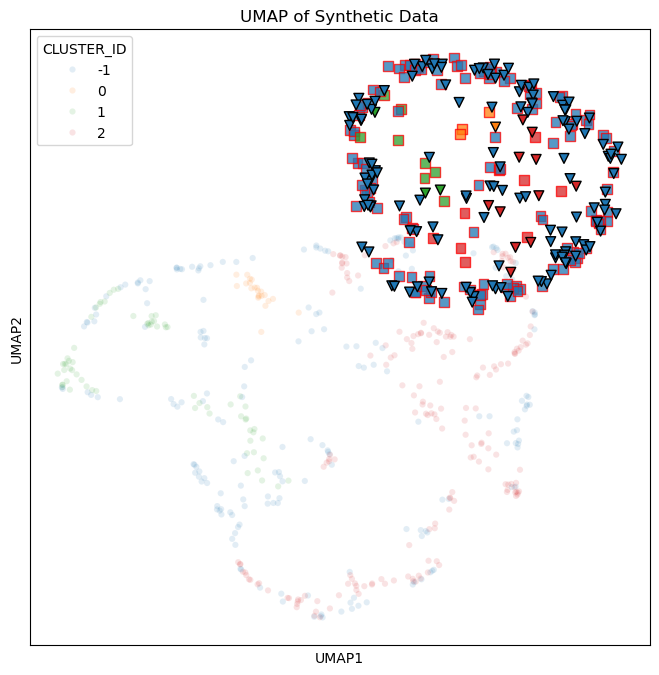

In [75]:
# plot the umap coordinates
plt.figure(figsize=(8,8))

# the data used to train the reducer and clusterer
sns.scatterplot(data = X_train_reduced, x='UMAP1', y='UMAP2', legend = True, hue = 'CLUSTER_ID', palette = "tab10", alpha = 0.125, marker = "o", s = 20)

# eval
sns.scatterplot(data = Xer, x='UMAP1', y='UMAP2', legend = False, hue = 'CLUSTER_ID', palette = "tab10", alpha = 0.75, marker = "s", s = 50, edgecolor = 'r', linewidth = 1.0, label = "Eval")

# holdout
sns.scatterplot(data = Xhr, x='UMAP1', y='UMAP2', legend = False, hue = 'CLUSTER_ID', palette = "tab10", alpha = 1.0, marker = "v", s = 50, edgecolor = 'k', linewidth = 1.0, label = "Holdout")


# turn off ticks
plt.tick_params(
    axis='both',          # changes apply to the x-axis and y-axis
    which='both',         # both major and minor ticks are affected
    bottom=False,         # ticks along the bottom edge are off
    left=False,           # ticks along the top edge are off
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off


plt.title("UMAP of Synthetic Data")

In [67]:
# train an rfc to predict cluster using just reduced dims as features
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

ftrs = ['UMAP1', 'UMAP2']

# split the data
# X_train, X_test= train_test_split(X_train_reduced,test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train_reduced[ftrs], clusterer.labels_, test_size=0.33, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_train_reduced, cluster_id, test_size=0.33, random_state=42)

# train the model
rfc = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
rfc.fit(X_train[ftrs], y_train)

# predict the test data
y_pred = rfc.predict(X_test[ftrs])
y_proba = rfc.predict_proba(X_test[ftrs])

# get the accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)


ValueError: Found input variables with inconsistent numbers of samples: [700, 469]

In [ ]:
X_train

,UMAP1,UMAP2
137,8.034083,11.281814
486,6.637970,6.619851
571,7.145968,10.866808
33,10.597336,8.526390
588,7.529508,6.980097
...,...,...
71,10.668924,8.797107
106,5.821315,9.980832
270,6.274359,10.524807
435,7.752672,10.952388


In [68]:
pd.DataFrame(y_proba).describe()

,0,1,2
count,231.000000,231.000000,231.000000
mean,0.437464,0.093039,0.469498
std,0.073422,0.147956,0.165786
min,0.313793,0.003739,0.060064
25%,0.379893,0.005679,0.387010
50%,0.417805,0.011650,0.545222
75%,0.459144,0.098623,0.589528
max,0.643563,0.541521,0.635623


<Axes: xlabel='UMAP1', ylabel='UMAP2'>

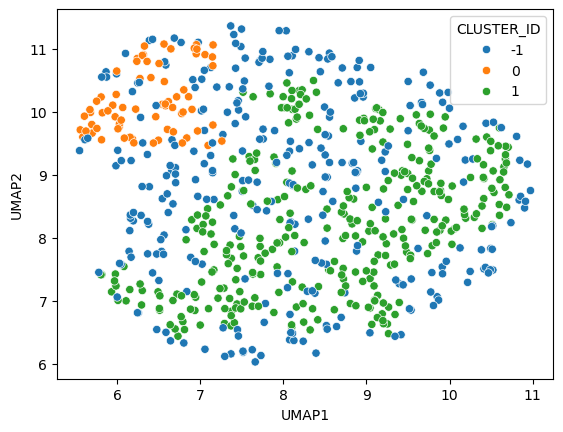

In [69]:
sns.scatterplot(data = X_train_reduced, x='UMAP1', y='UMAP2', legend = True, hue = 'CLUSTER_ID', palette = "tab10", marker = "o")

In [53]:
import joblib

# save the model
joblib.dump(rfc, "rfc.joblib")
# joblib.dump(coords, "umap.joblib")
foo = joblib.load("rfc.joblib")

In [54]:
foo.feature_importances_

array([0.4804916, 0.5195084])

In [55]:
foo.predict(X_test)

array([ 0, -1,  1,  1, -1,  0,  1,  1, -1, -1,  1,  1,  0,  1, -1,  1, -1,
        1,  1, -1,  1, -1,  1,  1,  1, -1,  1,  1, -1, -1,  1,  1,  0,  1,
        1,  0,  1,  1, -1,  0,  1,  1,  1,  1, -1,  1,  1, -1,  1, -1,  1,
       -1, -1, -1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  0,  1, -1,
       -1,  1,  1, -1, -1,  1, -1,  1,  1,  1, -1,  1, -1, -1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  0,  1,  1, -1,  0,  1,  1, -1,  1,  1,  1,
       -1,  1,  0, -1,  1, -1,  1,  1, -1,  1,  0,  1,  1,  0,  0,  1, -1,
        1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,
        1, -1,  1,  1,  0,  1,  1, -1,  1, -1, -1, -1,  1,  1,  1,  1, -1,
        0,  1,  1,  1, -1,  1, -1,  1,  1, -1, -1,  1,  0,  1,  0,  0, -1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  0,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  0,  1,  1,  0,  1, -1, -1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  0,
        1, -1, -1, -1,  1

In [56]:
(foo.predict(X_test) - y_test).sum()

67